In [24]:
import torch
import torchvision.transforms.functional
from torch import nn
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [3]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)

In [4]:
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)

In [5]:
class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

In [6]:
class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        x = torch.cat([x, contracting_x], dim=1)
        return x

In [122]:
class UNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 2):
        super().__init__()
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                        [(in_channels, 64), (64, 128), (128, 256), (256, 512)]]);
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)]);
        self.middle_conv = DoubleConvolution(512, 1024);
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]]);
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                      [(1024, 512), (512, 256), (256, 128), (128, 64)]]);
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)]);
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1);

    def forward(self, x: torch.Tensor):
        pass_through = []
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            pass_through.append(x)
            x = self.down_sample[i](x)

        x = self.middle_conv(x)

        for i in range(len(self.up_conv)):
            x = self.up_sample[i](x)
            x = self.concat[i](x, pass_through.pop())
            x = self.up_conv[i](x)

        x = self.final_conv(x)
        return x

In [123]:
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, non_trainable_params

model = UNet().to(device=device)
trainable, non_trainable = count_parameters(model)
trainable, non_trainable = "{:,}".format(trainable), "{:,}".format(non_trainable)
print(f"Unet model: {model}")
print(f"Trainable parameters: {trainable}")
print(f"Non-trainable parameters: {non_trainable}")

Unet model: UNet(
  (down_conv): ModuleList(
    (0): DoubleConvolution(
      (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (1): DoubleConvolution(
      (first): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (2): DoubleConvolution(
      (first): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (3): DoubleConvolution(
      (first): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): Re

In [145]:
img = cv2.imread('./cat.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
re_img = cv2.resize(img, (576, 576))
re_img = torch.tensor(re_img/255., dtype=torch.float32, device=device)
re_img.shape

torch.Size([576, 576, 3])

In [146]:
pred = model(re_img.unsqueeze(0).permute(0, 3, 1, 2))
pred = pred.squeeze().permute(1, 2, 0)
# pred = pred*255.

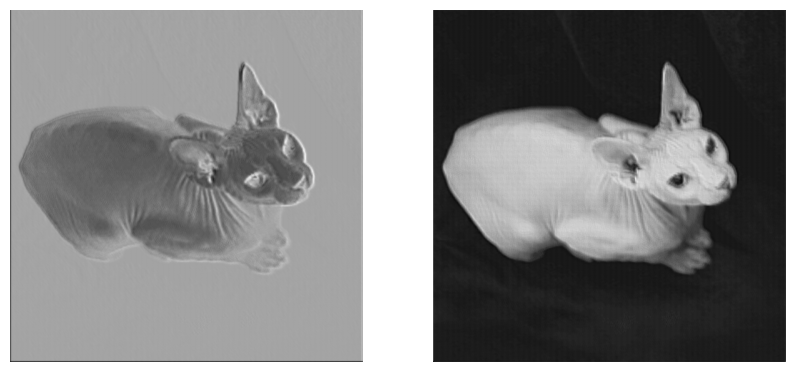

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(pred.cpu().detach().numpy()[:, :, 0], cmap='gray');
axes[1].imshow(pred.cpu().detach().numpy()[:, :, 1], cmap='gray');

axes[0].axis('off');
axes[1].axis('off');